In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
k = -1
b = 3 # y = kx + b => y = -x + 3 => y + x - 3 = 0
N_SAMPLES = 100
LOWER = -10.
UPPER = 10.

In [3]:
R = numpy.random.uniform(low=LOWER, high=UPPER, size=(N_SAMPLES, 2))
df = pandas.DataFrame(R, columns=['x', 'y'])
df.head()

,x,y
0,9.320661,7.228578
1,1.542660,-7.346473
2,0.854295,1.817756
3,-9.434882,2.404651
4,-2.457432,-6.590706


In [4]:
df = df.assign(c=-1)
df.head()

,x,y,c
0,9.320661,7.228578,-1
1,1.542660,-7.346473,-1
2,0.854295,1.817756,-1
3,-9.434882,2.404651,-1
4,-2.457432,-6.590706,-1


In [5]:
df.loc[df.y - k * df.x - b >= 0., 'c'] = 1
df[df.c == 1].head()

,x,y,c
0,9.320661,7.228578,1
5,0.292825,6.551387,1
8,2.694958,0.934432,1
11,9.406227,4.718128,1
12,4.795908,8.742930,1


In [6]:
df[df.c == -1].head()

,x,y,c
1,1.542660,-7.346473,-1
2,0.854295,1.817756,-1
3,-9.434882,2.404651,-1
4,-2.457432,-6.590706,-1
6,1.637907,-3.550379,-1


In [7]:
def plot_dataset(df, k, b):
    plt.scatter(df.x, df.y, c=df.c)
    x_all = numpy.arange(LOWER - 2., UPPER + 2.)
    plt.plot(x_all, k * x_all + b)

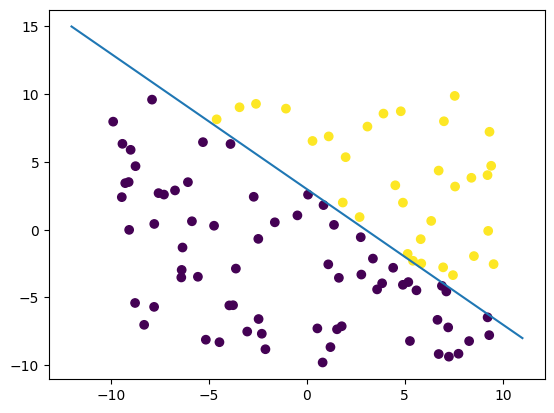

In [8]:
plot_dataset(df, k, b)

In [9]:
df.loc[:, 'x'] += numpy.random.normal(0., 1., size=N_SAMPLES)
df.loc[:, 'y'] += numpy.random.normal(0., 1., size=N_SAMPLES)

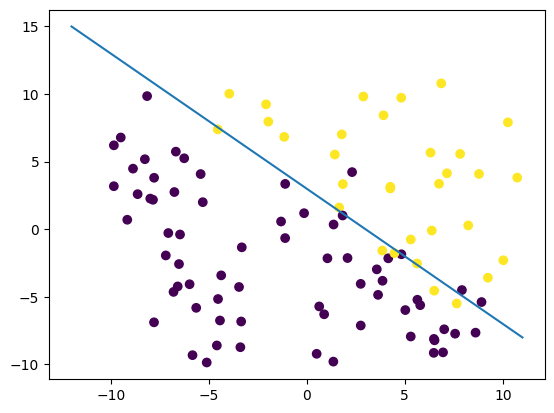

In [10]:
plot_dataset(df, k, b)

In [11]:
df[['x', 'y', 'c']].to_csv('points.csv', index=False)

In [12]:
from pyspark.sql import SparkSession

In [21]:
spark = SparkSession.builder.appName('Logistic-Regression').getOrCreate()
spark.sparkContext.setLogLevel('WARN')

In [14]:
data = spark.read.option("header", True).csv('points.csv').rdd
data.take(10)

[Row(x='10.259914722690626', y='7.908735266330252', c='1'),
 Row(x='2.7533287119370877', y='-7.118304947363691', c='-1'),
 Row(x='-1.3118115433912814', y='0.5743814261191467', c='-1'),
 Row(x='-8.628227486253174', y='2.59782051175759', c='-1'),
 Row(x='-4.427073801662841', y='-6.747402981148223', c='-1'),
 Row(x='-1.151222853393819', y='6.8343243488662315', c='1'),
 Row(x='2.7514364828029363', y='-4.037836030186152', c='-1'),
 Row(x='1.0538257622314444', y='-2.1469153858124503', c='-1'),
 Row(x='1.65066326622466', y='1.6118763691602962', c='1'),
 Row(x='7.56607435407082', y='-7.722829624224372', c='-1')]

In [15]:
from pyspark.sql.types import Row

def process_row(row):
    d = row.asDict()
    
    x = float(d['x'])
    y = float(d['y'])
    d['features'] = numpy.array([x, y, 1.], dtype=float)
    del d['x']
    del d['y']
    d['c'] = int(d['c'])
    
    return Row(**d)

data = data.map(process_row).cache()
data.take(3)

[Row(c=1, features=array([10.25991472,  7.90873527,  1.        ])),
 Row(c=-1, features=array([ 2.75332871, -7.11830495,  1.        ])),
 Row(c=-1, features=array([-1.31181154,  0.57438143,  1.        ]))]

In [16]:
w = numpy.random.normal(size=3)
w # x * w[0] + y * w[1] + w[2] = 0 => y = (-w[0] / w[1]) * x + (-w[2] / w[1])

array([ 0.92341797, -1.17841148,  2.06684285])

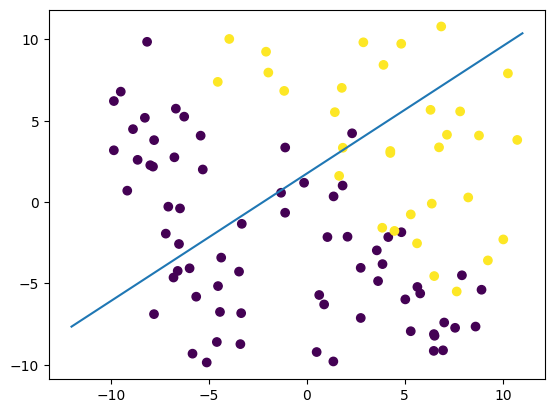

In [17]:
plot_dataset(df, k = -w[0] / w[1], b = -w[2] / w[1])

In [18]:
import math

def sigmoid(x):
    return 1. / (1. + math.exp(-x))

def grad_mapper(row):
    z = numpy.dot(w, row.features)
    return -row.features * row.c * sigmoid(-row.c * z)

N_POINTS = data.count()
N_ITERS = 100
ALPHA = 0.1
for i in range(N_ITERS):
    grads = data.map(grad_mapper)
    grad = grads.sum() / N_POINTS
    w -= ALPHA * grad

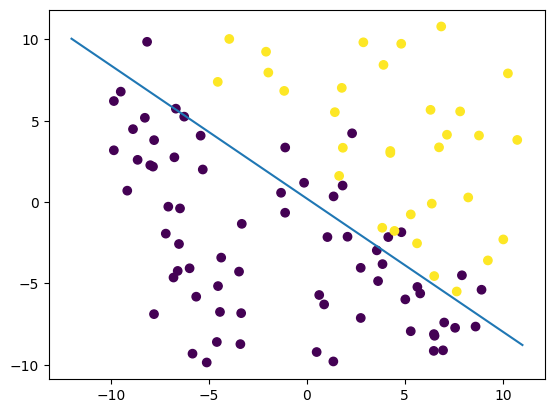

In [20]:
plot_dataset(df, k = -w[0] / w[1], b = -w[2] / w[1])